# Predicting fetal states based on Cardiotocography (CTG)

Cardiotocography is an essential indicator of fetal states. Earlier detection of a pathological fetus allows physicians to take action to prevent mortality. The results of machine learning models can inform obstetricians in determining the fetal states. This project uses the random forest to train a model to predict three fetal states (Normal, Suspect, Pathological).

#### CTG output has 4 parts. 
* A: Fetal heartbeat; 
* B: Indicator showing movements felt by mother (triggered by pressing a button); 
* C: Fetal movement; 
* D: Uterine contractions

## Dataset sources:
- [the UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Cardiotocography)

### Features:
#### Exam data:
    FileName - of CTG examination
    Date - of the examination
    b - start instant
    e - end instant
#### Measurements:
    LBE - baseline value (medical expert)
    LB - baseline value (SisPorto)
    AC - accelerations (SisPorto)
    FM - fetal movement (SisPorto)
    UC - uterine contractions (SisPorto)
    ASTV - percentage of time with abnormal short term variability  (SisPorto)
    mSTV - mean value of short term variability  (SisPorto)
    ALTV - percentage of time with abnormal long term variability  (SisPorto)
    mLTV - mean value of long term variability  (SisPorto)
    DL - light decelerations
    DS - severe decelerations
    DP - prolongued decelerations
    DR - repetitive decelerations
    Width - histogram width
    Min - low freq. of the histogram
    Max - high freq. of the histogram
    Nmax - number of histogram peaks
    Nzeros - number of histogram zeros
    Mode - histogram mode
    Mean - histogram mean
    Median - histogram median
    Variance - histogram variance
    Tendency - histogram tendency: -1=left assymetric; 0=symmetric; 1=right assymetric
#### Classification:
    A - calm sleep
    B - REM sleep
    C - calm vigilance
    D - active vigilance
    SH - shift pattern (A or Susp with shifts)
    AD - accelerative/decelerative pattern (stress situation)
    DE - decelerative pattern (vagal stimulation)
    LD - largely decelerative pattern
    FS - flat-sinusoidal pattern (pathological state)
    SUSP - suspect pattern
    CLASS - Class code (1 to 10) for classes A to SUSP
    NSP - Normal=1; Suspect=2; Pathologic=3

## Data Cleaning

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

import math
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report

In [2]:
raw_data = pd.read_table("CTG.csv", sep = ",")
raw_data

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,5/3/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,5/3/1996,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,S8001045.dsp,6/6/1998,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2125,S8001045.dsp,6/6/1998,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove meaningless rows
df = raw_data.drop([2126,2127,2128])

In [6]:
df.NSP.value_counts()

1.0    1655
2.0     295
3.0     176
Name: NSP, dtype: int64

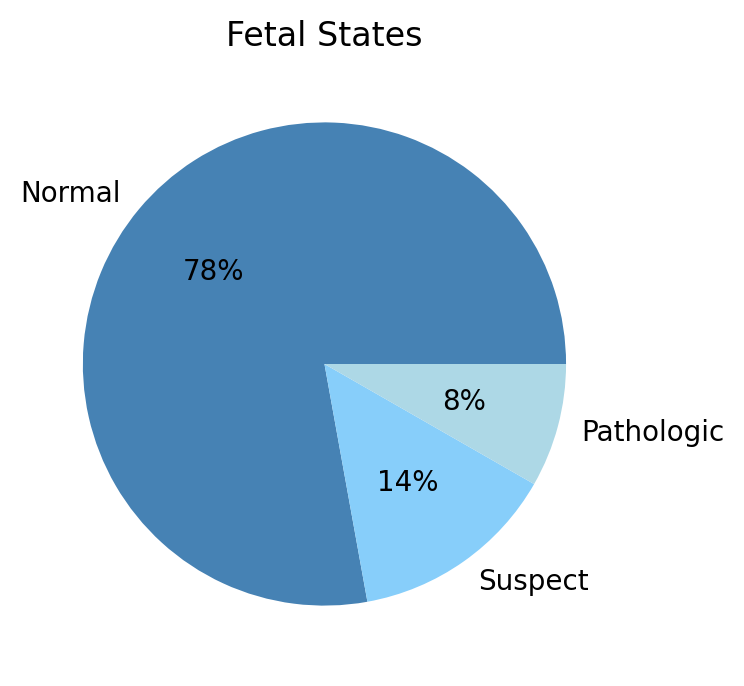

In [4]:
fetal_states = df.NSP.value_counts().to_frame()

plt.figure(dpi=200)
pie_fetal_states = plt.pie(fetal_states.NSP, labels=["Normal", "Suspect", "Pathologic"], 
                           colors = ["steelblue", "lightskyblue", "lightblue"], autopct="%1.0f%%")
plt.title("Fetal States");

In [5]:
# remove FileName, Date, and SegFile
df = df.drop(['FileName', 'Date', 'SegFile'], axis = 1)
# remove b, e
df = df.drop(['b', 'e'], axis = 1)
# remove A, B, C, D, E, AD, DE, LD, FS, SUSP, and CLASS
df = df.drop(['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS'], axis = 1)
df

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,120.0,0.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,132.0,4.0,0.0,4.0,17.0,2.1,0.0,10.4,2.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,133.0,2.0,0.0,5.0,16.0,2.1,0.0,13.4,2.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,134.0,2.0,0.0,6.0,16.0,2.4,0.0,23.0,2.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,132.0,4.0,0.0,5.0,16.0,2.4,0.0,19.9,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,140.0,0.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,140.0,1.0,0.0,9.0,78.0,0.4,22.0,7.1,0.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,140.0,1.0,0.0,7.0,79.0,0.4,20.0,6.1,0.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,140.0,1.0,0.0,9.0,78.0,0.4,27.0,7.0,0.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
LB,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
AC,2126.0,2.722484,3.560850,0.0,0.0,1.0,4.0,26.0
FM,2126.0,7.241298,37.125309,0.0,0.0,0.0,2.0,564.0
UC,2126.0,3.659925,2.847094,0.0,1.0,3.0,5.0,23.0
ASTV,2126.0,46.990122,17.192814,12.0,32.0,49.0,61.0,87.0
MSTV,2126.0,1.332785,0.883241,0.2,0.7,1.2,1.7,7.0
ALTV,2126.0,9.846660,18.396880,0.0,0.0,0.0,11.0,91.0
MLTV,2126.0,8.187629,5.628247,0.0,4.6,7.4,10.8,50.7
DL,2126.0,1.570085,2.499229,0.0,0.0,0.0,3.0,16.0


In [8]:
df.Tendency.value_counts()

 0.0    1115
 1.0     846
-1.0     165
Name: Tendency, dtype: int64

In [11]:
# remove b, e
df = df.drop(['DS', 'DR'], axis = 1)

In [12]:
df.columns.unique()

Index(['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'NSP'],
      dtype='object')

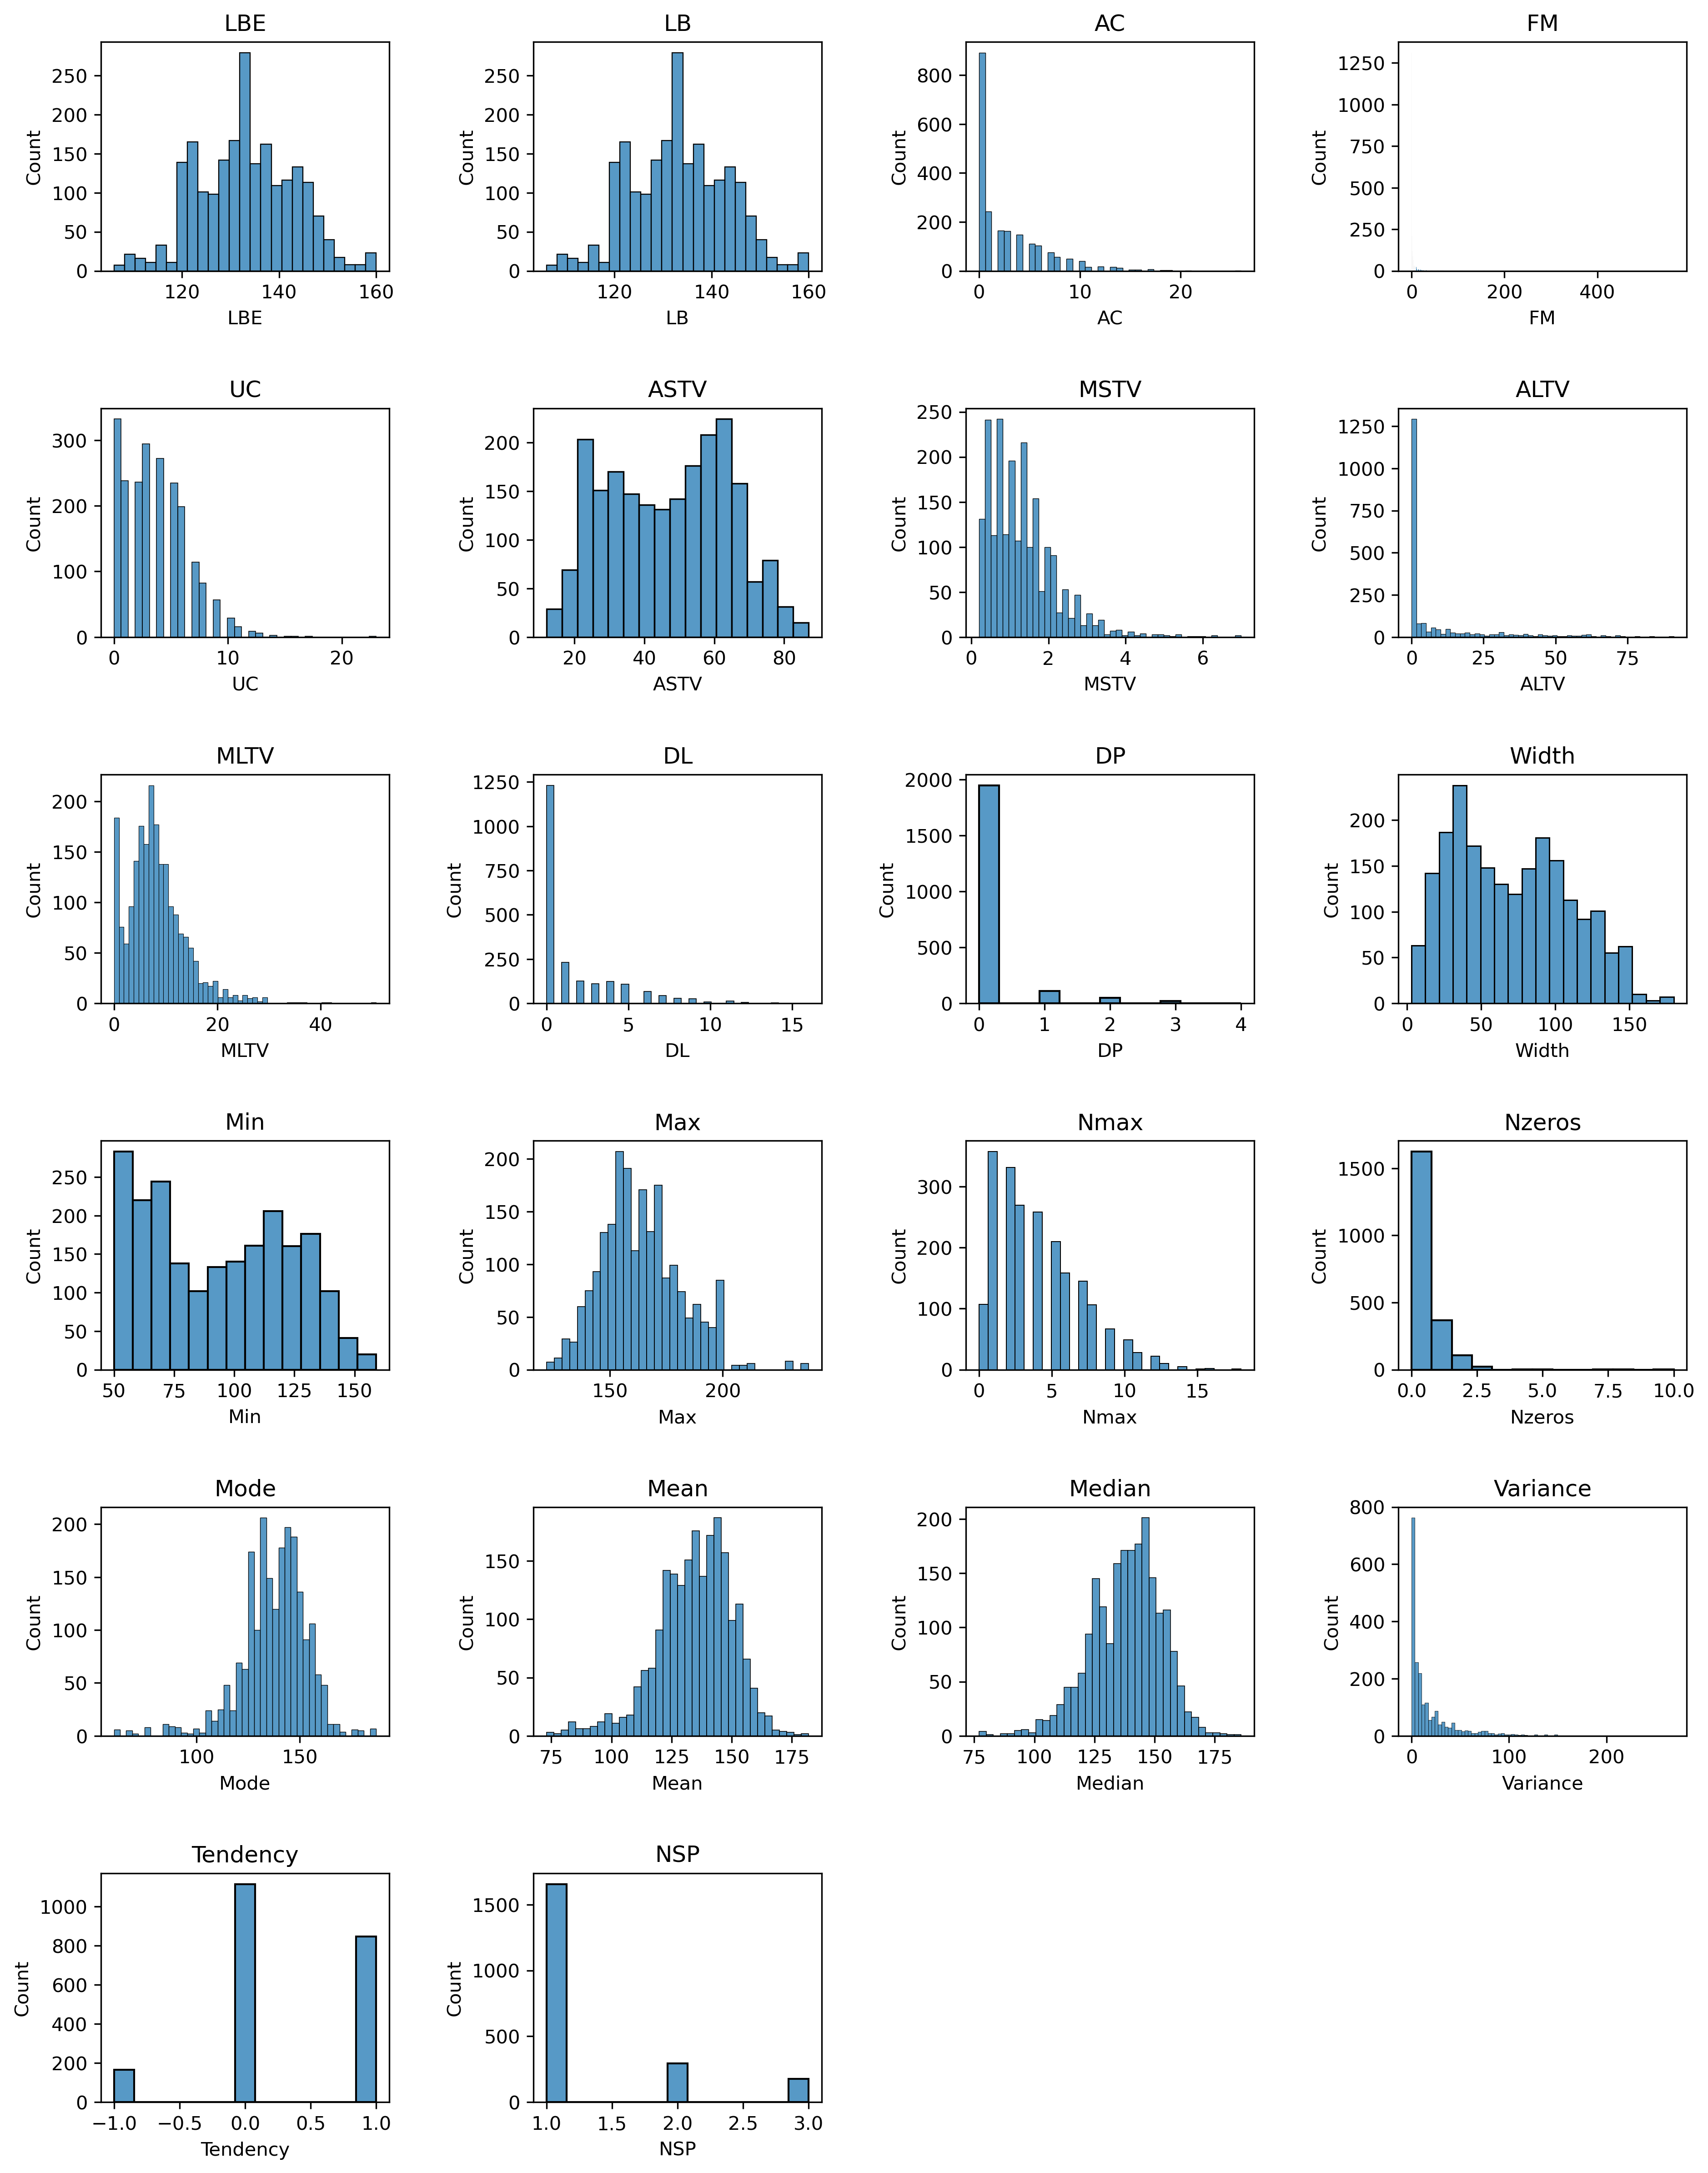

In [13]:
his = ['LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'NSP']

fig = plt.figure(figsize=(15,20), dpi=300)
for i in range(0,22):
    plt.subplots_adjust(wspace=0.5,hspace=0.6)
    ax = fig.add_subplot(6,4,i + 1)
    sns.histplot(x = df[his[i]])
    plt.title(his[i])

In [14]:
# remove FM 
df = df.drop(['FM'], axis = 1)
# remove Tendency for heatmap
df_heatmap = df.drop(['Tendency'], axis = 1)

<Figure size 2400x1600 with 0 Axes>

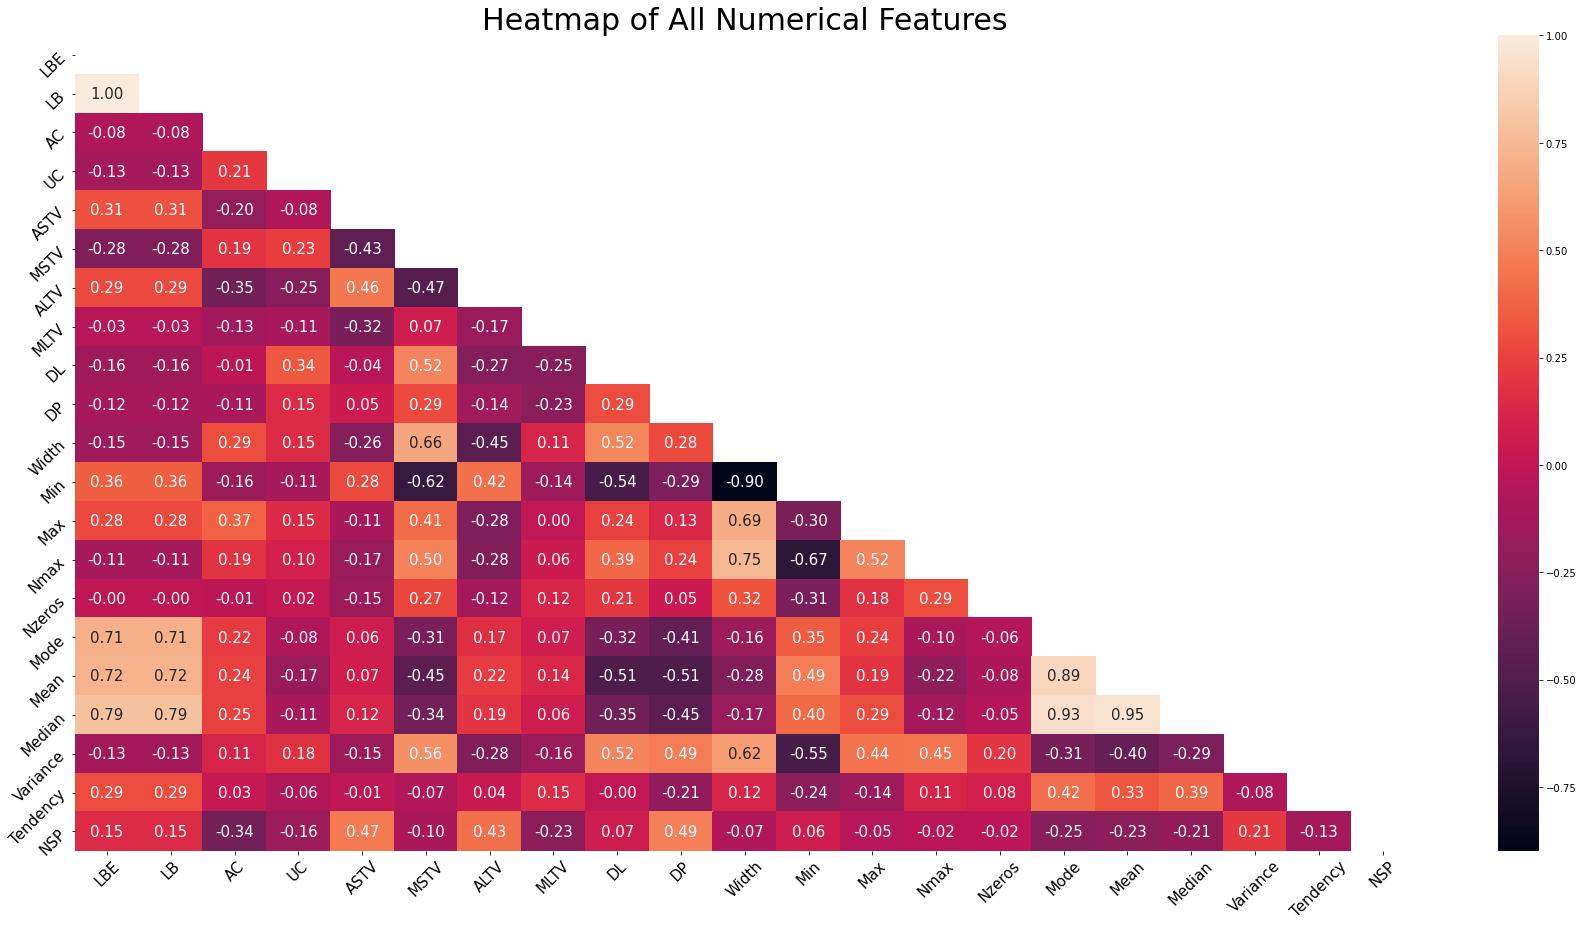

In [15]:
warnings.filterwarnings("ignore") 
df_heatmap.corr()
plt.figure(dpi=400)
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot = True, fmt = '.2f', annot_kws={'size': 15}, 
            mask = np.triu(np.ones_like(df.corr(), dtype = np.bool)))
plt.xticks(fontsize=15, rotation = 45)
plt.yticks(fontsize=15, rotation = 45)
plt.title("Heatmap of All Numerical Features", fontsize = 30);

In [16]:
# 0.8 - 1.0
# LBE & LB
# Min & Width
# Mean & Mode & Median

# keep LB, Width, and Mode

# remove LBE, Min, Mean, Median
df = df.drop(['LBE', 'Min', 'Mean', 'Median'], axis = 1)
df

,LB,AC,UC,ASTV,MSTV,ALTV,MLTV,DL,DP,Width,Max,Nmax,Nzeros,Mode,Variance,Tendency,NSP
0,120.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,64.0,126.0,2.0,0.0,120.0,73.0,1.0,2.0
1,132.0,4.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,130.0,198.0,6.0,1.0,141.0,12.0,0.0,1.0
2,133.0,2.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,130.0,198.0,5.0,1.0,141.0,13.0,0.0,1.0
3,134.0,2.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,117.0,170.0,11.0,0.0,137.0,13.0,1.0,1.0
4,132.0,4.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,117.0,170.0,9.0,0.0,137.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,40.0,177.0,4.0,0.0,153.0,2.0,0.0,2.0
2122,140.0,1.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,66.0,169.0,6.0,0.0,152.0,3.0,1.0,2.0
2123,140.0,1.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,67.0,170.0,5.0,0.0,153.0,4.0,1.0,2.0
2124,140.0,1.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,66.0,169.0,6.0,0.0,152.0,4.0,1.0,2.0


In [17]:
#  DP and Tendency
DP_and_Tendency = df.loc[:, ['Tendency', 'NSP']]
DP_and_Tendency

,Tendency,NSP
0,1.0,2.0
1,0.0,1.0
2,0.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
2121,0.0,2.0
2122,1.0,2.0
2123,1.0,2.0
2124,1.0,2.0


In [19]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

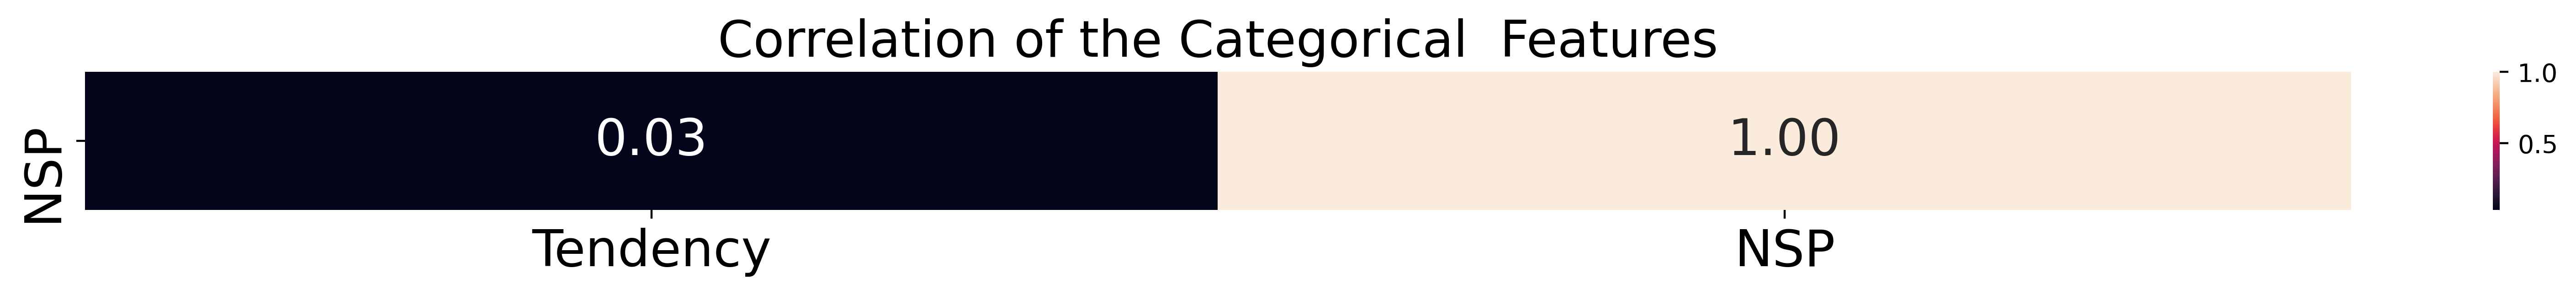

In [20]:
theilu = pd.DataFrame(index=['NSP'],columns=DP_and_Tendency.columns)
columns = DP_and_Tendency.columns
for j in range(0,len(columns)):
    u = theil_u(DP_and_Tendency['NSP'].tolist(),DP_and_Tendency[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1), dpi=400)
sns.heatmap(theilu,annot=True,fmt='.2f', annot_kws={'size': 20},)
plt.title("Correlation of the Categorical  Features", fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
plt.show()

In [21]:
# remove Tendency
df = df.drop(['Tendency'], axis = 1)
df

,LB,AC,UC,ASTV,MSTV,ALTV,MLTV,DL,DP,Width,Max,Nmax,Nzeros,Mode,Variance,NSP
0,120.0,0.0,0.0,73.0,0.5,43.0,2.4,0.0,0.0,64.0,126.0,2.0,0.0,120.0,73.0,2.0
1,132.0,4.0,4.0,17.0,2.1,0.0,10.4,2.0,0.0,130.0,198.0,6.0,1.0,141.0,12.0,1.0
2,133.0,2.0,5.0,16.0,2.1,0.0,13.4,2.0,0.0,130.0,198.0,5.0,1.0,141.0,13.0,1.0
3,134.0,2.0,6.0,16.0,2.4,0.0,23.0,2.0,0.0,117.0,170.0,11.0,0.0,137.0,13.0,1.0
4,132.0,4.0,5.0,16.0,2.4,0.0,19.9,0.0,0.0,117.0,170.0,9.0,0.0,137.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.0,6.0,79.0,0.2,25.0,7.2,0.0,0.0,40.0,177.0,4.0,0.0,153.0,2.0,2.0
2122,140.0,1.0,9.0,78.0,0.4,22.0,7.1,0.0,0.0,66.0,169.0,6.0,0.0,152.0,3.0,2.0
2123,140.0,1.0,7.0,79.0,0.4,20.0,6.1,0.0,0.0,67.0,170.0,5.0,0.0,153.0,4.0,2.0
2124,140.0,1.0,9.0,78.0,0.4,27.0,7.0,0.0,0.0,66.0,169.0,6.0,0.0,152.0,4.0,2.0


## Dataset splitting

In [22]:
## feature dataframe
X = df.drop(['NSP'], axis = 1)
## target dataframe
Y = df.loc[:, ['NSP']]
y = Y.values.ravel()

## Retain 40% samples as the test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 515, stratify=df['NSP'])
y_train = y_train.values.ravel()

In [24]:
#A quick model selection process
#pipelines of models( it is short was to fit and pred)
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state= 515))])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state= 515))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier(random_state= 515))])

pipeline_svc=Pipeline([('sv_classifier',SVC(random_state= 515))])


# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: "SVC"}


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(x_train, y_train)

#cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, x_train, y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))


Logistic Regression: 0.875234 
Decision Tree: 0.907431 
RandomForest: 0.928580 
SVC: 0.830598 


## RandomForest Model

In [25]:
RF = RandomForestClassifier(random_state = 515)
score = cross_val_score(RF,X,y,cv=10).mean()
print('gini score: %.4f'%score)
RF = RandomForestClassifier(criterion = 'entropy',random_state = 515)
score = cross_val_score(RF,X,y,cv=10).mean()
print('entropy score: %.4f'%score)

gini score: 0.8729
entropy score: 0.8757


0.9576968272620446 94


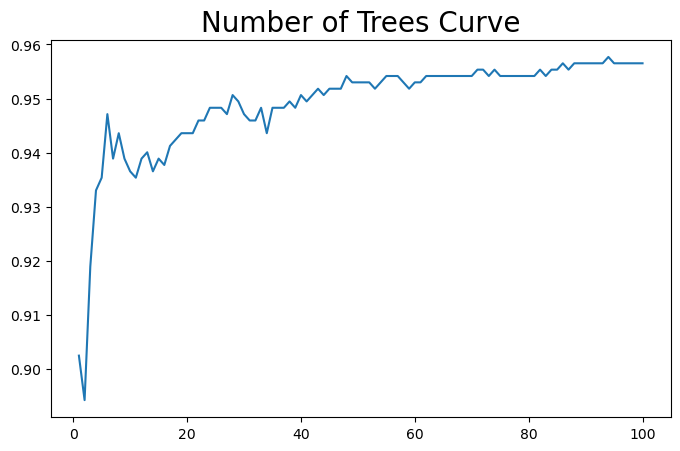

In [26]:
superpa = []
for i in range(100):
    rfc = RandomForestClassifier(criterion = 'entropy', n_estimators=i+1, random_state = 515, max_features = 'sqrt', bootstrap = True, oob_score = False)
    rfc_s_mod = rfc.fit(x_train, y_train)
    rfc_s = rfc.score(x_test, y_test)
    superpa.append(rfc_s)
print(max(superpa),superpa.index(max(superpa))+1)
plt.figure(figsize=[8,5], dpi = 100)
plt.plot(range(1,101),superpa)
plt.title("Number of Trees Curve", fontsize = 20)
plt.show()

0.9588719153936546 20


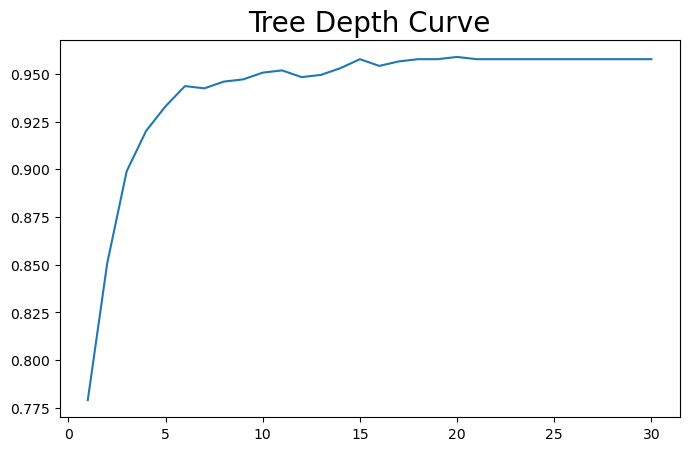

In [27]:
MD_L = []
for i in range(30):
    MD = RandomForestClassifier(criterion = 'entropy', n_estimators=94, max_depth =i+1, 
                                random_state = 515, max_features = 'sqrt', bootstrap = True, oob_score = False)
    MD_s_mod = MD.fit(x_train, y_train)
    MD_s = MD.score(x_test, y_test)
    MD_L.append(MD_s)
print(max(MD_L),MD_L.index(max(MD_L))+1)
plt.figure(figsize=[8,5], dpi = 100)
plt.plot(range(1,31),MD_L)
plt.title("Tree Depth Curve", fontsize = 20)
plt.show()

0.9588719153936546 2


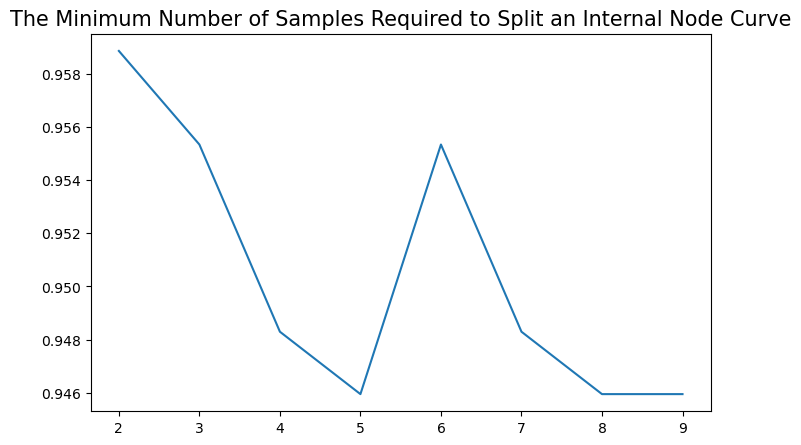

In [28]:
MSS_L = []
for i in range(2, 10):
    MSS = RandomForestClassifier(criterion = 'entropy', n_estimators = 94, max_depth = 20, min_samples_split = i,
                                 random_state = 515, max_features = 'sqrt', bootstrap = True, oob_score = False)
    MSS_s_mod = MSS.fit(x_train, y_train)
    MSS_s = MSS.score(x_test, y_test)
    MSS_L.append(MSS_s)
print(max(MSS_L),MSS_L.index(max(MSS_L))+2)
plt.figure(figsize=[8,5], dpi = 100)
plt.plot(range(2,10),MSS_L)
plt.title("The Minimum Number of Samples Required to Split an Internal Node Curve", fontsize = 15)
plt.show()

0.9588719153936546 1


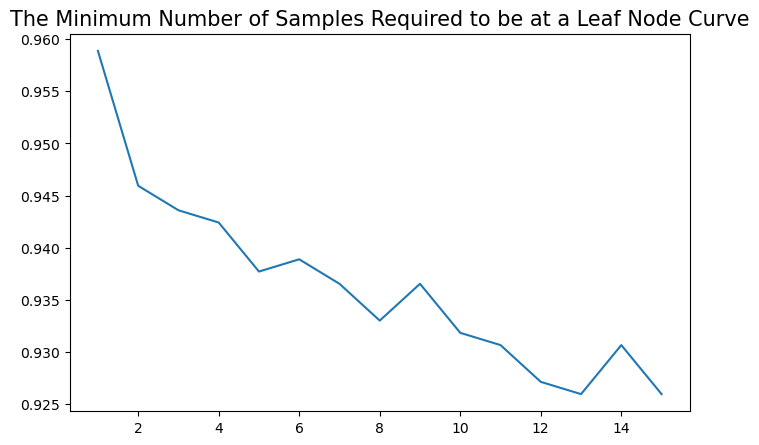

In [29]:
MSL_L = []
for i in range(15):
    MSL = RandomForestClassifier(criterion = 'entropy', n_estimators = 94, max_depth = 20, min_samples_split = 2, min_samples_leaf = i+1,
                                       random_state = 515, max_features = 'sqrt', bootstrap = True, oob_score = False)
    MSL_s_mod = MSL.fit(x_train, y_train)
    MSL_s = MSL.score(x_test, y_test)
    MSL_L.append(MSL_s)
print(max(MSL_L),MSL_L.index(max(MSL_L))+1)
plt.figure(figsize=[8,5], dpi = 100)
plt.plot(range(1,16),MSL_L)
plt.title("The Minimum Number of Samples Required to be at a Leaf Node Curve", fontsize = 15)
plt.show()

0.9588719153936546 3


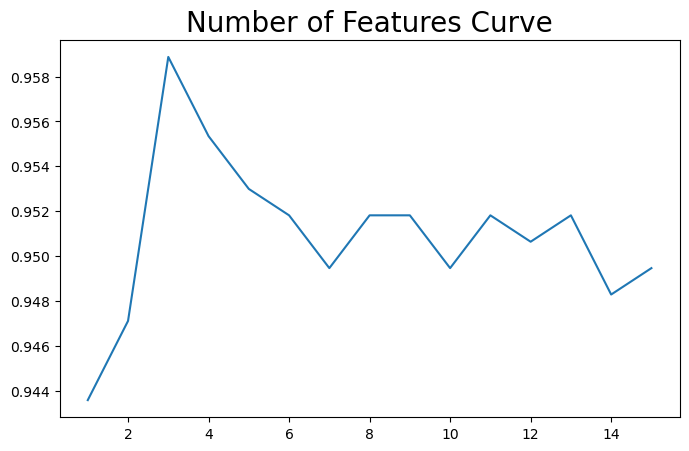

In [30]:
MF_L = []
for i in range(15):
    MF = RandomForestClassifier(criterion = 'entropy', n_estimators = 94, max_depth = 20, min_samples_split = 2, min_samples_leaf = 1,
                                       random_state = 515, max_features = i+1, bootstrap = True, oob_score = False)
    MF_s_mod = MF.fit(x_train, y_train)
    MF_s = MF.score(x_test, y_test)
    MF_L.append(MF_s)
print(max(MF_L),MF_L.index(max(MF_L))+1)
plt.figure(figsize=[8,5], dpi = 100)
plt.plot(range(1,16),MF_L)
plt.title("Number of Features Curve", fontsize = 20)
plt.show()

In [31]:
# Final model

random_forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 94, max_depth = 20, min_samples_split = 2, min_samples_leaf = 1,
                                       random_state = 515, max_features = 3, bootstrap = True, oob_score = False)
random_forest_mod = random_forest.fit(x_train, y_train)

In [32]:
train_score = random_forest.score(x_train, y_train)
test_score = random_forest.score(x_test, y_test)

print('train_score: ' , train_score)
print('test_score: ' , test_score)

train_score:  0.9984313725490196
test_score:  0.9588719153936546


In [34]:
predictions=random_forest.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.96      0.99      0.98       663
         2.0       0.94      0.81      0.87       118
         3.0       0.98      0.89      0.93        70

    accuracy                           0.96       851
   macro avg       0.96      0.89      0.93       851
weighted avg       0.96      0.96      0.96       851



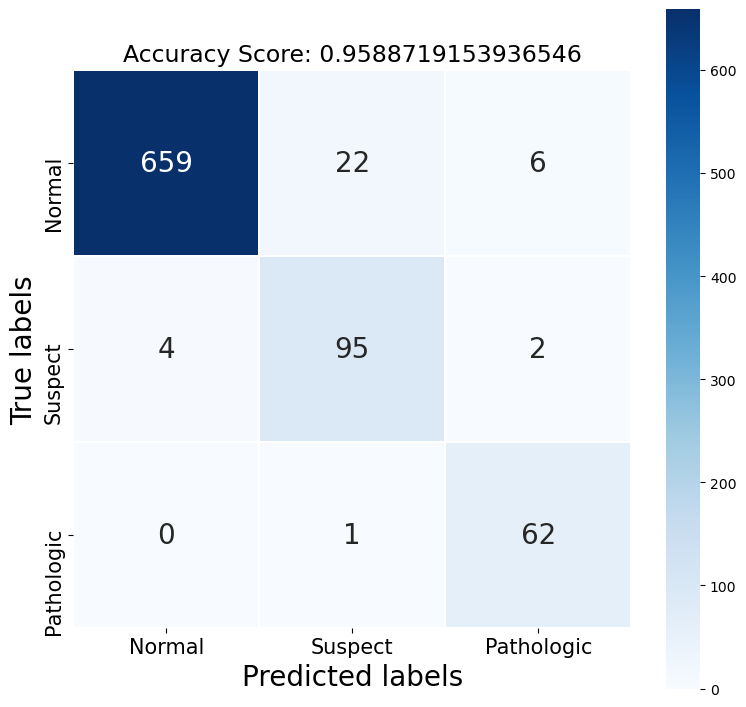

In [35]:
## confusion matrix
test_predict = random_forest.predict(x_test)
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)

plt.figure(figsize=(9, 9), dpi=100)
sns.heatmap(confusion_matrix_result, annot=True, 
            fmt=".0f", linewidths=.5, square = True, 
            cmap= 'Blues', annot_kws={"size": 20},
            xticklabels = ['Normal', 'Suspect', 'Pathologic'],
            yticklabels = ['Normal', 'Suspect', 'Pathologic'],)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Predicted labels', fontsize = 20);
plt.ylabel('True labels', fontsize = 20);
plt.title('Accuracy Score: {}'.format(metrics.accuracy_score(y_test,test_predict)), size = 17);
plt.show()

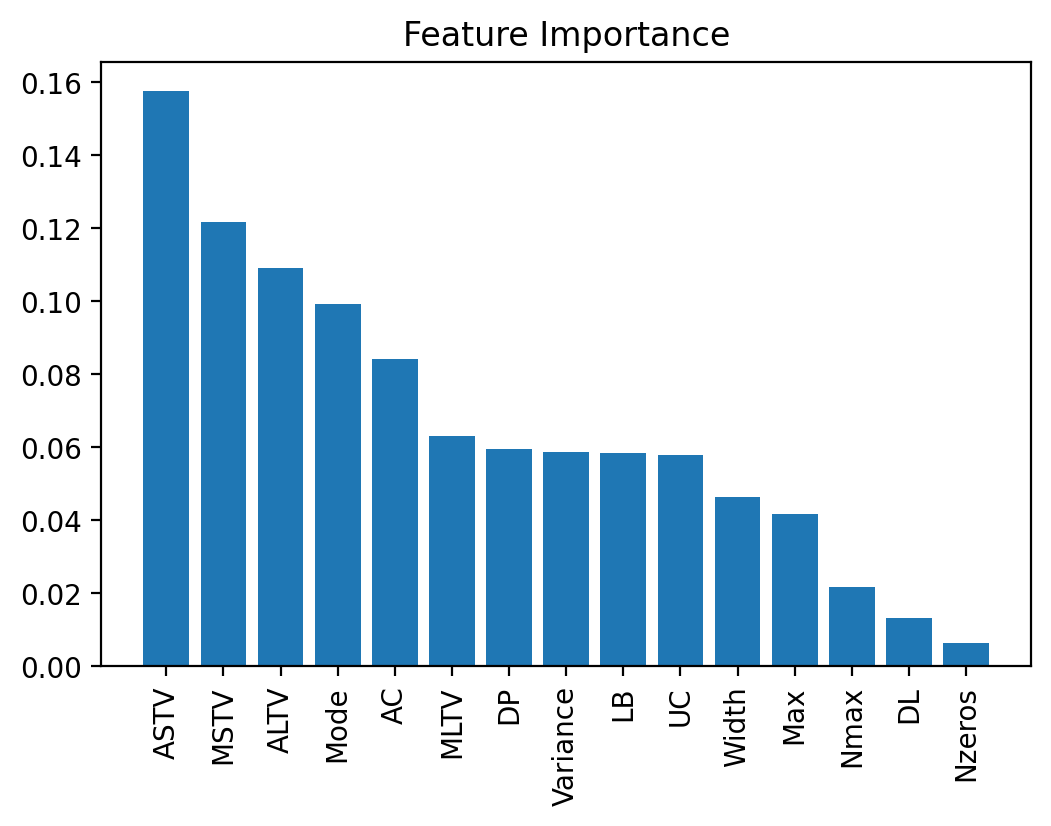

In [36]:
Features = ['LB', 'AC', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DP', 'Width',
       'Max', 'Nmax', 'Nzeros', 'Mode', 'Variance']


importances = random_forest_mod.feature_importances_
#print("model.feature_importances_: {}".format(importances))

# print(importances)
# 对特征重要性进行排序
indices = np.argsort(importances)[::-1]
#print(indices)
# 获取特征名字
names = [Features[i] for i in indices]
# 创建图
plt.figure(dpi=200)
plt.title("Feature Importance")
# features.shape[1]  数组的长度
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation= 90)
plt.show()